# Coffea-Casa Processor-Based Workflow Test with Metrics

This notebook demonstrates the UnifiedProcessor workflow with coffea.processor.Runner on Coffea-Casa, including skimming, analysis, histogramming, statistics steps, and **comprehensive performance metrics collection**.

## Workflow Overview

1. Setup Python path for intccms package
2. Install dependencies and register modules for cloud pickle
3. Acquire Dask client from Coffea-Casa environment
4. Configure analysis parameters (including metrics)
5. Run metadata extraction
6. Initialize UnifiedProcessor
7. Run processor with coffea.processor.Runner
8. **Collect and display performance metrics**
9. Save histograms
10. Run statistical analysis (if enabled)

In [1]:
# Setup Python path to include intccms package
import sys
import time
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")

✅ Added /home/cms-jovyan/integration-challenge/cms/src to Python path
✅ Added /home/cms-jovyan/integration-challenge/cms to Python path


In [2]:
COFFEA_VERSION = "2025.10.3.dev17+g2cde65fb6" # 2025.10.2
COFFEA_PIP = "git+https://github.com/scikit-hep/coffea@master"
try:
    import omegaconf
except ImportError:
    print("⚠️ omegaconf not found, installing...")
    ! pip install omegaconf

try:
    import coffea
    print("Coffea version: ", coffea.__version__)
    # assert coffea.__version__ == "2025.10.3.dev9+g41c84f7a9"
except (ImportError, AssertionError):
    print("⚠️ coffea not found or incorrect version, installing...")
    ! pip install $COFFEA_PIP
print("✅ All dependencies are installed.")

Coffea version:  2025.10.0
✅ All dependencies are installed.


In [3]:
# Imports and cloudpickle registration
import copy
import os

os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""

from dask.distributed import Client, PipInstall
from coffea.processor import DaskExecutor
from coffea.nanoevents import NanoAODSchema

import cloudpickle
import intccms
import example_cms

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)

from example_cms.configs.configuration import config as original_config
from intccms.schema import Config, load_config_with_restricted_cli
from intccms.utils.output import OutputDirectoryManager
from intccms.metadata_extractor import DatasetMetadataManager
from intccms.datasets import DatasetManager
from intccms.analysis import run_processor_workflow

## Acquire Dask Client

Coffea-Casa provides a shared scheduler. Connect to it and register dependencies.

In [4]:
def acquire_client():
    """Acquire Dask client from Coffea-Casa environment."""
    client = Client("tls://localhost:8786")
    dependencies = [COFFEA_PIP] #["coffea==2025.10.2"]
    client.register_plugin(PipInstall(packages=dependencies))
    cluster = None  # no local cluster in this mode
    return client, cluster

## Configuration Setup

Configure analysis parameters including which processes to run, output settings, and **metrics collection**.

In [5]:
# Configuration setup
config = copy.deepcopy(original_config)

# Limit files for testing
config["datasets"]["max_files"] = 10

# Use local output directory
config["general"]["output_dir"] = "example_cms/outputs_with_metrics/"

# Configuration flags
config["general"]["read_from_cache"] = False
config["general"]["run_metadata_generation"] = False
config["general"]["run_processor"] = True  # Set to False to skip processor and load saved histograms
config["general"]["save_skimmed_output"] = False  # Set to True to save filtered events to disk
config["general"]["run_analysis"] = True
config["general"]["run_histogramming"] = True
config["general"]["run_systematics"] = True
config["general"]["run_statistics"] = False

# ===== ENABLE METRICS COLLECTION =====
config["general"]["metrics"] = {
    "enable": True,                    # Master switch
    "track_workers": True,             # Enable scheduler-based tracking
    "save_measurements": True,         # Save to disk
}

# Test only signal dataset
#config["general"]["processes"] = ["data"]

cli_args = []
full_config = load_config_with_restricted_cli(config, cli_args)
validated_config = Config(**full_config)

print(f"✅ Configuration loaded with max_files={validated_config.datasets.max_files}")
print(f"   - run_processor: {validated_config.general.run_processor}")
print(f"   - save_skimmed_output: {validated_config.general.save_skimmed_output}")
print(f"   - run_analysis: {validated_config.general.run_analysis}")
print(f"   - run_histogramming: {validated_config.general.run_histogramming}")
print(f"   - run_systematics: {validated_config.general.run_systematics}")
print(f"   - run_statistics: {validated_config.general.run_statistics}")
print(f"   - metrics.enable: {validated_config.general.metrics.enable}")
print(f"   - metrics.track_workers: {validated_config.general.metrics.track_workers}")

✅ Configuration loaded with max_files=10
   - run_processor: True
   - save_skimmed_output: False
   - run_analysis: True
   - run_histogramming: True
   - run_systematics: True
   - run_statistics: False
   - metrics.enable: True
   - metrics.track_workers: True


## Run Complete Workflow

Execute the full processor workflow with proper cleanup in a try/finally block.

In [6]:
try:
    client, cluster = acquire_client()
    print(f"✅ Connected to Dask scheduler")
    print(f"📊 Dashboard: {client.dashboard_link}")
    
    # Output Manager Setup
    output_manager = OutputDirectoryManager(
        root_output_dir=validated_config.general.output_dir,
        cache_dir=validated_config.general.cache_dir,
        metadata_dir=validated_config.general.metadata_dir,
        skimmed_dir=validated_config.general.skimmed_dir
    )
    print(f"✅ Output directory: {output_manager.root_output_dir}")

    # Step 1: Metadata Extraction
    print("\n📋 Extracting metadata...")
    dataset_manager = DatasetManager(validated_config.datasets)
    metadata_generator = DatasetMetadataManager(
        dataset_manager=dataset_manager,
        output_manager=output_manager,
        executor=DaskExecutor(client=client),
        config=validated_config,
    )
    metadata_generator.run(
        generate_metadata=validated_config.general.run_metadata_generation,
        processes_filter=validated_config.general.processes if hasattr(validated_config.general, 'processes') else None
    )

    metadata_lookup = metadata_generator.build_metadata_lookup()
    workitems = metadata_generator.workitems

    print(f"✅ Generated {len(workitems)} workitems")

    # Show first few workitems
    print("\n🔍 Workitem Details (first 5):")
    for i, wi in enumerate(workitems[:5]):
        print(f"  {i}: dataset='{wi.dataset}' process='{wi.usermeta.get('process', 'N/A')}'")
    if len(workitems) > 5:
        print(f"  ... and {len(workitems) - 5} more")

    # Step 2: Run Processor Workflow (or load saved histograms)
    print("\n🚀 Running processor workflow...")
    t0 = time.perf_counter()
    output, report, metrics = run_processor_workflow(
        config=validated_config,
        output_manager=output_manager,
        metadata_lookup=metadata_lookup,
        workitems=workitems,
        executor=DaskExecutor(client=client, treereduction=8, retries=0),
        schema=NanoAODSchema,
    )
    t1 = time.perf_counter()
    print("✅ Processor workflow complete!")

    # Step 3: Display Results
    print("\n" + "=" * 60)
    print("📊 Results:")
    print("=" * 60)

    if validated_config.general.run_processor:
        print(f"📊 Total events processed: {output.get('processed_events', 0):,}")
        if 'skimmed_events' in output:
            print(f"✂️  Events after skim: {output.get('skimmed_events', 0):,}")

    # Histograms are auto-saved by processor
    if output and "histograms" in output:
        num_histograms = sum(len(hists) for hists in output["histograms"].values())
        print(f"📈 Total histograms: {num_histograms}")
        print(f"📈 Channels: {list(output['histograms'].keys())}")
        print(f"✅ Histograms auto-saved to: {output_manager.histograms_dir}")
        print(f"   - processor_histograms.pkl (for loading with run_processor=False)")
        print(f"   - histograms.root (for downstream tools)")
    else:
        print("\n⚠️  No histograms produced (run_histogramming may be disabled)")

    # Summary
    print("\n" + "=" * 60)
    print("✅ Complete processor workflow finished!")
    print("=" * 60)

finally:
    # Cleanup
    print("\n🧹 Cleaning up...")
    # Note: Don't close client yet - we need it for metrics display
    client.close()
    print("✅ Workflow complete!")

✅ Connected to Dask scheduler
📊 Dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status


12:04:34 INFO     Output directory manager initialized with root:                                ]8;id=534886;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/directories.py\directories.py]8;;\:]8;id=237800;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/directories.py#169\169]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics                      

✅ Output directory: /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics

📋 Extracting metadata...


         INFO     Initialized dataset manager with 10 datasets                                        ]8;id=736297;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/datasets/manager.py\manager.py]8;;\:]8;id=555475;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/datasets/manager.py#34\34]8;;\

         INFO     Initialized DatasetMetadataManager with output dir:                                ]8;id=55908;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=940157;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#131\131]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/metada               
                  ta                                                                                               

         INFO     Loading existing metadata from:                                                    ]8;id=159739;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=988351;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#221\221]8;;\
                  {                                                                                                
                      'fileset_path':                                                                              
                  PosixPath('/home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_met               
                  rics/metadata/fileset.json'),                                                                    
                      'workitems_path':                                                                            
                  PosixPath('/home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_met               
                  rics/metadata/workitems.json'),                                                                  
                      'nanoaods_summary_path':                                                                     
                  PosixPath('/home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_met               
                  rics/metadata/nanoaods.json')                                                                    
                  }                                                                                                

         INFO     Loaded 10 Dataset objects from fileset                                             ]8;id=109640;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=216526;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#326\326]8;;\

         INFO     Loaded 4348 WorkItems                                                              ]8;id=418674;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=912182;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#333\333]8;;\

         INFO     Loaded event count summary                                                         ]8;id=49958;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=169066;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#339\339]8;;\

         INFO     All metadata successfully loaded from disk.                                        ]8;id=745222;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=429356;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#229\229]8;;\

         INFO     Built metadata lookup for 125 fileset keys                                         ]8;id=102264;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=695848;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#427\427]8;;\

✅ Generated 4348 workitems

🔍 Workitem Details (first 5):
  0: dataset='signal_0__nominal' process='signal'
  1: dataset='signal_0__nominal' process='signal'
  2: dataset='signal_1__nominal' process='signal'
  3: dataset='signal_1__nominal' process='signal'
  4: dataset='signal_1__nominal' process='signal'
  ... and 4343 more

🚀 Running processor workflow...


         INFO     Running processor over data...                                                      ]8;id=929676;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=164625;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#125\125]8;;\

         INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=718896;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=16743;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py#194\194]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Started worker tracking on scheduler                                                ]8;id=18636;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=746757;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#216\216]8;;\

         INFO     Processing 4348 work items with chunksize=200000                                    ]8;id=923506;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=856413;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#247\247]8;;\

Output()

12:08:16 INFO     Postprocessing complete: 789020628 total events                                  ]8;id=203773;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=966780;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py#382\382]8;;\

         INFO     Histograms written to pickle:                                                    ]8;id=695241;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=538763;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py#45\45]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/hist                 
                  ograms/processor_histograms.pkl                                                                  

         INFO     Saved processor histograms (pickle) to                                           ]8;id=763215;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=783867;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py#394\394]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/hist                 
                  ograms/processor_histograms.pkl                                                                  

         INFO     Filtered 8 invalid systematic variations from data samples                      ]8;id=69004;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=162208;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py#188\188]8;;\

         INFO     Histograms written to ROOT file:                                                ]8;id=999056;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=618205;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/utils/output/histograms.py#137\137]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/his                  
                  tograms/histograms.root                                                                          

         INFO     Saved processor histograms (ROOT) to                                             ]8;id=552584;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=303470;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/processor.py#402\402]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/hist                 
                  ograms/histograms.root                                                                           

12:08:20 INFO     Processor complete: 789,020,628 events processed, 30,372,939 events after skim      ]8;id=460431;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=387746;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#263\263]8;;\

12:08:21 INFO     Saved worker timeline to                                                            ]8;id=905817;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=493745;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#278\278]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchma              
                  rks/20251106-120434                                                                              

         INFO     Saved metrics measurement to                                                        ]8;id=569986;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=316808;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#296\296]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchma              
                  rks/20251106-120434                                                                              

         INFO     📊 Dask performance report:                                                         ]8;id=444858;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=261058;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#300\300]8;;\
                  /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchma              
                  rks/20251106-120434/dask_performance.html                                                        

         INFO     📈 Metrics: 2.43 Gbps, 3497.5 kHz                                                   ]8;id=969562;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=607080;file:///home/cms-jovyan/integration-challenge/cms/src/intccms/analysis/runner.py#303\303]8;;\

✅ Processor workflow complete!

📊 Results:
📊 Total events processed: 789,020,628
✂️  Events after skim: 30,372,939
📈 Total histograms: 1
📈 Channels: ['CMS_WORKSHOP']
✅ Histograms auto-saved to: /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/histograms
   - processor_histograms.pkl (for loading with run_processor=False)
   - histograms.root (for downstream tools)

⚠️  Statistics step skipped (disabled or no histograms)

✅ Complete processor workflow finished!

🧹 Cleaning up...
✅ Workflow complete!


## Performance Metrics

Display comprehensive performance metrics collected during processing.

In [7]:
# Display Coffea Report
report

{'bytesread': 68636235303,
 'columns': ['Jet_jetId',
  'Muon_tightId',
  'nFatJet',
  'Muon_eta',
  'HLT_Mu50',
  'Muon_pt',
  'nJet',
  'Muon_miniIsoId',
  'Pileup_nTrueInt',
  'run',
  'Jet_pt',
  'FatJet_mass',
  'nMuon',
  'PuppiMET_pt',
  'Jet_btagDeepB',
  'PuppiMET_phi',
  'FatJet_phi',
  'luminosityBlock',
  'Jet_eta',
  'Jet_phi',
  'Muon_mass',
  'Jet_mass',
  'FatJet_pt',
  'FatJet_particleNet_TvsQCD',
  'FatJet_eta',
  'genWeight',
  'Muon_phi'],
 'entries': 789020628,
 'processtime': 14165.624266386032,
 'chunks': 4348}

In [8]:
# Import Rich for beautiful table display
from rich.console import Console

console = Console()

print("\n" + "=" * 60)
print("📊 Processing Metrics")
print("=" * 60)


📊 Processing Metrics


In [9]:
# Display metrics if collection was enabled
if metrics:
    from intccms.metrics import (
        format_throughput_table,
        format_event_processing_table,
        format_resources_table,
        format_timing_table,
    )
    
    print("\n📈 Throughput Metrics")
    console.print(format_throughput_table(metrics))
    
    print("\n⚡ Event Processing Metrics")
    console.print(format_event_processing_table(metrics))
    
    print("\n🖥️  Resource Utilization")
    console.print(format_resources_table(metrics))
    
    print("\n⏱️  Timing Breakdown")
    console.print(format_timing_table(metrics))
else:
    print("⚠️  Metrics collection was disabled (set config.general.metrics.enable=True)")


📈 Throughput Metrics


                        Throughput Metrics                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric            ┃ Value                                       ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Data Rate         │ 2.43 Gbps (304.2 MB/s)                      │
│ Compression Ratio │ 2.50x                                       │
│ Total Data Read   │ 63.92 GB compressed, 159.81 GB uncompressed │
└───────────────────┴─────────────────────────────────────────────┘


⚡ Event Processing Metrics


            Event Processing Metrics            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Events               │ 789,020,628     │
│ Event Rate (Wall Clock)    │ 3497.5 kHz      │
│ Event Rate (Aggregated)    │ 55.7 kHz        │
│ Event Rate (Core-Averaged) │ 12632.5 Hz/core │
│ Efficiency Ratio           │ 6279.2%         │
└────────────────────────────┴─────────────────┘


🖥️  Resource Utilization


       Resource Utilization        
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                  ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Workers (Time-Averaged) │ 276.9 │
│ Peak Workers            │ 383   │
│ Total Cores             │ 277   │
│ Core Efficiency         │ 22.7% │
│ Speedup Factor          │ 62.8x │
└─────────────────────────┴───────┘


⏱️  Timing Breakdown


         Timing Breakdown         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric             ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Wall Time          │ 3m 45s    │
│ Total CPU Time     │ 3h 56m 5s │
│ Number of Chunks   │ 4,348     │
│ Avg CPU Time/Chunk │ 3.3s      │
└────────────────────┴───────────┘

## Manual Calculations for Verification

Compare automated metrics to manual calculations from the coffea report.

In [10]:
print("\n" + "=" * 60)
print("🔍 Manual Calculations (for verification)")
print("=" * 60)

if report:
    print(f"data read: {report['bytesread'] / 1000**3:.2f} GB in {report['chunks']} chunks")
    print(f"")
    print(f"core-average event rate using 'processtime': {report['entries'] / 1000 / report['processtime']:.2f} kHz")
    print(f"core-average data rate using 'processtime': {report['bytesread'] / 1000**3 * 8 / report['processtime']:.2f} Gbps")
    print(f"")
    print(f"average event rate using walltime: {report['entries'] / 1000 / (t1 - t0):.2f} kHz")
    print(f"average data rate using walltime: {report['bytesread'] / 1000**3 * 8 / (t1 - t0):.2f} Gbps")
    print(f"")
    print(f"Number of branches read: {len(report['columns'])}")
    
    print("\n✅ Compare manual calculations to metrics tables above!")
    print("   - Wall-clock rates should match 'Event Rate (Wall Clock)' and 'Data Rate'")
    print("   - Processtime rates should match 'Event Rate (Aggregated)'")
else:
    print("No report available")


🔍 Manual Calculations (for verification)
data read: 68.64 GB in 4348 chunks

core-average event rate using 'processtime': 55.70 kHz
core-average data rate using 'processtime': 0.04 Gbps

average event rate using walltime: 3483.08 kHz
average data rate using walltime: 2.42 Gbps

Number of branches read: 27

✅ Compare manual calculations to metrics tables above!
   - Wall-clock rates should match 'Event Rate (Wall Clock)' and 'Data Rate'
   - Processtime rates should match 'Event Rate (Aggregated)'


## Dask Performance Report

Link to the detailed Dask performance report HTML file.

In [20]:
# Find the latest benchmark directory
benchmarks_dir = output_manager.benchmarks_dir
latest_dirs = sorted(benchmarks_dir.glob("*"), key=lambda p: p.name, reverse=True)
measurement_path = None if not latest_dirs else latest_dirs[1]  # Most recent timestamped directory
print(f"📊 Loading worker tracking data from: {measurement_path}")

if metrics and validated_config.general.metrics.track_workers:
    perf_report_path = output_manager.benchmarks_dir / "latest" / "dask_performance.html"
    print(f"\n📊 Dask Performance Report: {perf_report_path}")
    print("   Download this file and open in a browser for detailed task timeline visualization")
    print("   Includes task execution timeline, worker utilization, and communication patterns")
else:
    print("\n⚠️  Performance report not generated (metrics.track_workers=False)")

📊 Loading worker tracking data from: /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchmarks/20251106-120434

📊 Dask Performance Report: /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchmarks/latest/dask_performance.html
   Download this file and open in a browser for detailed task timeline visualization
   Includes task execution timeline, worker utilization, and communication patterns


   - Tracking duration: 220 samples
   - Workers tracked: 432

📊 Generating summary dashboard...
✅ Dashboard saved to: /home/cms-jovyan/integration-challenge/cms/example_cms/outputs_with_metrics/benchmarks/20251106-120434/summary_dashboard.png


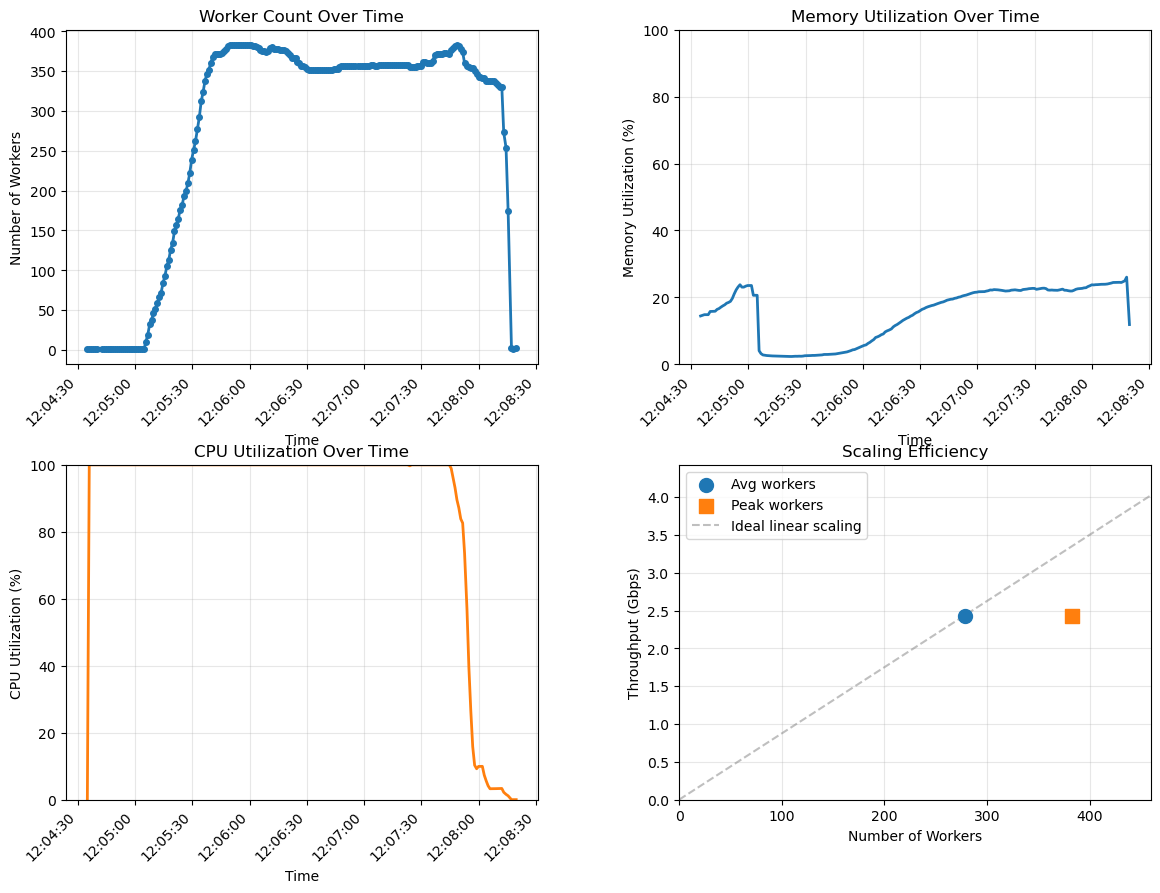

In [23]:
from intccms.metrics import (
    load_worker_timeline,
    plot_summary_dashboard,
    plot_worker_count_timeline,
    plot_memory_utilization_timeline,
    plot_cpu_utilization_timeline,
    plot_scaling_efficiency,
)

# Generate visualizations if worker tracking was enabled
if metrics and validated_config.general.metrics.track_workers:
       
    try:
        # Load tracking data
        tracking_data = load_worker_timeline(measurement_path)
        
        print(f"   - Tracking duration: {len(tracking_data['worker_counts'])} samples")
        print(f"   - Workers tracked: {len(tracking_data['worker_memory'])}")
        
        # Generate summary dashboard
        print("\n📊 Generating summary dashboard...")
        fig = plot_summary_dashboard(
            tracking_data, 
            metrics, 
            output_path=measurement_path / "summary_dashboard.png"
        )
        
        print(f"✅ Dashboard saved to: {measurement_path / 'summary_dashboard.png'}")
            
    except Exception as e:
        print(f"⚠️  Failed to generate visualizations: {e}")
else:
    print("⚠️  Worker tracking was disabled - no visualizations to generate")

⚠️  Error: Memory or memory limit data not available


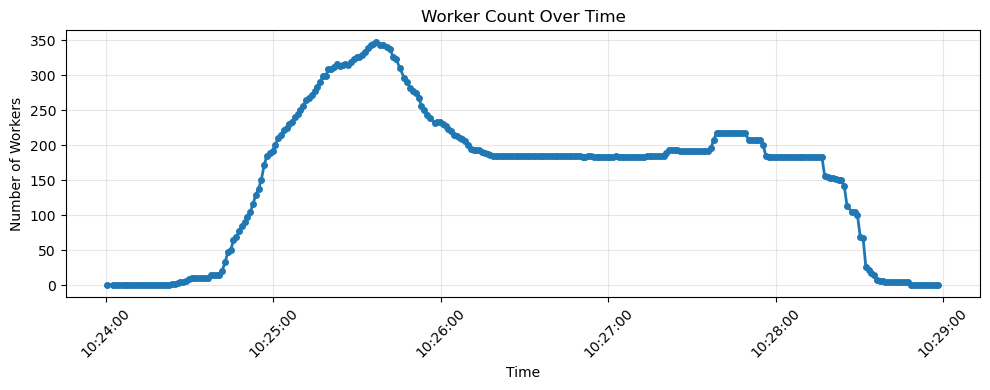

In [24]:
# Optional: Generate individual plots for detailed analysis
# Uncomment the plots you want to generate

if metrics and validated_config.general.metrics.track_workers and latest_dirs:
    measurement_path = latest_dirs[0]
    
    try:
        tracking_data = load_worker_timeline(measurement_path)
        
        # Worker count timeline
        fig, ax = plot_worker_count_timeline(
            tracking_data, 
            output_path=measurement_path / "worker_count.png"
        )
        
        # Memory utilization timeline
        fig, ax = plot_memory_utilization_timeline(
            tracking_data,
            output_path=measurement_path / "memory_utilization.png"
        )
        
        # CPU utilization timeline
        fig, ax = plot_cpu_utilization_timeline(
            tracking_data,
            output_path=measurement_path / "cpu_utilization.png"
        )
        
        # Scaling efficiency
        fig, ax = plot_scaling_efficiency(
            tracking_data,
            metrics,
            output_path=measurement_path / "scaling_efficiency.png"
        )
        
        print("💡 Tip: Uncomment the plots above to generate individual visualizations")
        
    except Exception as e:
        print(f"⚠️  Error: {e}")